## MLP3 Baseline Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [1]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.19.1


In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K


model = Sequential()
model.add(Flatten(input_shape=(28, 28, 3)))
model.add(Dense(512, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(512, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(512, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())



Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [84]:
BASELINE_outfile = 'cifar10_keras_mlp3.out'

BASELINE_final_weightfile = 'weights/model.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/model.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 45

BASELINE_init_weighfile = 'weights/model.b16.e0.h5'


REGULARIZED_final_weightfile = 'model.b16.wd.final.h5'
RANDOMIZED_final_weightfile = 'model.b16.rand100.final.h5'

In [51]:
!cd weights; ln -s model.b16.final.h5 model.b16e44.h5
!cd weights; ls -l model.b16e.44.h5

ls: model.b16e.44.h5: No such file or directory


## Baseline 

In [7]:
model.load_weights(BASELINE_final_weightfile)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 1,735,178
Trainable params: 1,735,178
Non-trainable params: 0
_________________________________________________________________
None


#### Check baseline shapes

In [8]:
for layer in model.layers:
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print(W.shape)
        

(2352, 512)
(512, 512)
(512, 512)
(512, 10)


### Generalized Entropy

In [9]:
# model for MLLP3 is defined above
def layer_entropy(l=2):
    W = model.layers[l].get_weights()[0]
    return matrix_entropy(W)

In [10]:
# model for MLLP3 is defined above
def layer_eiegnavlues(l=2):
    return matrix_eigenvalues(W)

In [11]:
def matrix_entropy(W, n=512):
    W=W/np.trace(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    rank = np.linalg.matrix_rank(W)
    p = sv*sv
    p = p/np.sum(p)
    
    if (rank==1):
        rank=1.000001
    entropy = - np.sum(p*np.log(p)) / np.log(rank) 
    return entropy


In [12]:
# Eigenvalues for correlation weight matrices, layers 2 and 3
def matrix_eigenvalues():
    W = model.layers[2].get_weights()[0]
    W = W / np.linalg.norm(W)
    WW = np.dot(W.transpose(),W)
    ev2s, _ = np.linalg.eig(WW)    
    
    W = model.layers[3].get_weights()[0]
    W = W / np.linalg.norm(W)
    WW = np.dot(W.transpose(),W)
    ev3s, _ = np.linalg.eig(WW)  
    
    return ev2s, ev3s

### Read Training Accuracies

We can simply parse these from the output file

In [13]:
def read_training_accuracies(filename):
    cmd = "cat ./{} | grep '50000/' | sed -e 's/.*acc://' ".format(filename)
    !$cmd > tmp.out
    result = np.loadtxt("tmp.out")
    !rm tmp.out
    return result

### Recompute Test Accuracies

In [14]:
img = tf.placeholder(tf.float32, [28, 28, 3])
norm_image = tf.image.per_image_standardization(img)

print("Loading test images...")
cifar10_test_images = []
cifar10_test_labels = []
test_file = open('../data/cifar-10-batches-py/test_batch', 'rb')
test_dict = pickle.load(test_file, encoding='bytes')

for image, label in zip(test_dict[b'data'], test_dict[b'labels']):
    image_red = np.reshape(image[:1024], (32, 32))[2:-2, 2:-2] / 255.0
    image_red = np.reshape(image_red, (28, 28, 1))
    image_green = np.reshape(image[1024:2048], (32, 32))[2:-2,
                                                            2:-2] / 255.0
    image_green = np.reshape(image_green, (28, 28, 1))
    image_blue = np.reshape(image[2048:3072], (32, 32))[2:-2, 2:-2] / 255.0
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image = np.concatenate([image_red, image_green, image_blue], axis=-1)
    image = norm_image.eval(feed_dict={img:image})
    cifar10_test_images.append(image)
    label = np.identity(10)[label]
    cifar10_test_labels.append(label)
test_file.close()

Loading test images...


## BASLINE

### Compute Entropy and Accuracies per Epoch

Baseline has 44 epochs...we can do more if necessary


In [50]:
w2_entropies, w3_entropies = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    w2_entropies.append(layer_entropy(2))
    w3_entropies.append(layer_entropy(3))

In [53]:
assert(len(w2_entropies)==NUM_BASELINE_EPOCHS)
assert(len(w3_entropies)==NUM_BASELINE_EPOCHS)

Text(0.5,1,'MLP3: Layer Entropies vs epoch ')

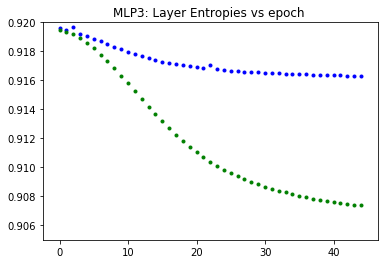

In [54]:
plt.scatter(range(0,len(w2_entropies)), w2_entropies, marker='.', color='blue')
plt.scatter(range(0,len(w3_entropies)), w3_entropies, marker='.', color='green')
plt.ylim([0.905,0.920])
plt.title('MLP3: Layer Entropies vs epoch ')

#### Read Baseline Training accuracies from output file

Notice: there is no epoch=0 training accuracy

In [38]:
bsln_train_accs = read_training_accuracies(BASELINE_outfile)
assert(len(bsln_train_accs)==NUM_BASELINE_EPOCHS)

#### Recompute Baseline Test accuracies 

In [39]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [74]:
bsln_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(cifar10_test_images),np.array(cifar10_test_labels), batch_size=256)
    bsln_test_accs.append(acc[1])

10000/10000 [==============================] - 1s 72us/step



Text(0.5,1,'MLP3: Layer Entropies vs epoch ')

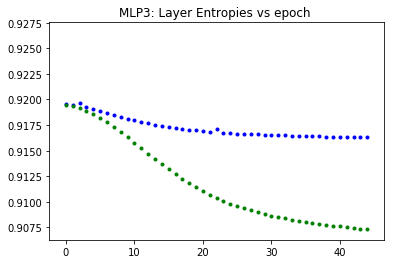

In [75]:
plt.scatter(range(0,len(w2_entropies)), w2_entropies, marker='.', color='blue')
plt.scatter(range(0,len(w3_entropies)), w3_entropies, marker='.', color='green')

plt.title('MLP3: Layer Entropies vs epoch ')

###  MLP3 is pretty bad, and easily overtrained</font>

### We see how the phase transition corresponds with overtraining on the training data 

#### But random would be %10, so it is not totally bananas

Text(0.5,1,'MLP3: Layer Entropies epoch vs generalized entropy')

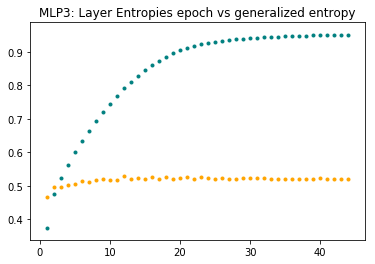

In [83]:
x = range(1,NUM_BASELINE_EPOCHS)

#plt.scatter(x, w2_entropies[1:], marker='.', color='blue')
#plt.scatter(x, w3_entropies[1:], marker='.', color='green')
plt.scatter(x, bsln_train_accs,  marker='.',color='teal')
plt.scatter(x, bsln_test_accs[1:],  marker='.',color='orange')

plt.title('MLP3: Layer Entropies epoch vs generalized entropy')

## Wigner SemiCircle Plots

### <font color='orange'>Not available yet </font>

## Marchenko Pastur FIts and Plots

$\lambda^{\pm}=\sigma_{mp}^{2}\left(1\pm\dfrac{1}{\sqrt Q}\right)^{2}$


In [118]:
def marchenko_pastur_pdf(x_min, x_max, Q, sigma=1):
    y=1/Q
    x=np.arange(x_min,x_max,0.001)

    b=np.power(sigma*(1 + np.sqrt(1/Q)),2) # Largest eigenvalue
    a=np.power(sigma*(1 - np.sqrt(1/Q)),2) # Smallest eigenvalue
    return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))

#### Get sigma from $\lambda_{max}$, $Q=1$

$\sigma^{2}=\lambda_{max}\left(1+\dfrac{1}{\sqrt{Q}}\right)^{-2}=\dfrac{1}{2}\lambda_{max}$

In [138]:
def calc_sigma(evs):
    lmax = np.max(evs)
    return 0.5*lmax

In [139]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [100]:
def get_eigenvalues(modelfile, layer=2):
    N, M = 512, 512
    model.load_weights(modelfile)
    W = model.layers[layer].get_weights()[0]
    X = np.dot(W.transpose(),W)/float(N)
    svd = TruncatedSVD(n_components=M-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    
    eigenvalues = sv*sv
    return eigenvalues

## Create 9 ESD plots, 3x3 grid

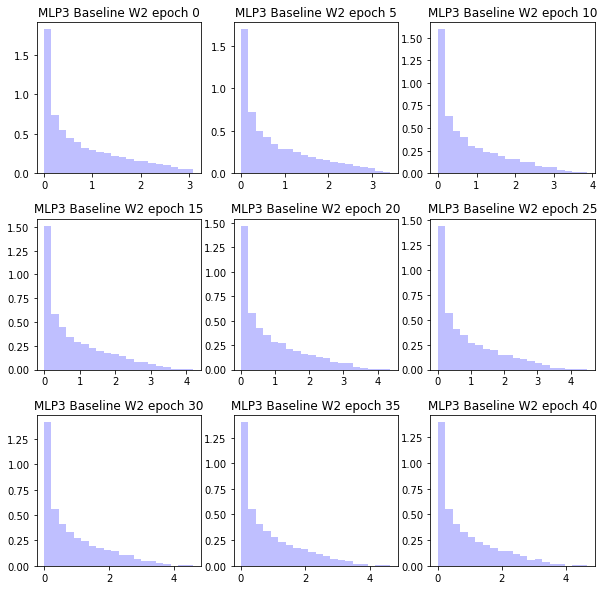

In [130]:
LAYER = 2
f, axes = plt.subplots(3,3)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,5)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = get_eigenvalues(modelfile, layer=LAYER)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("MLP3 Baseline W{} epoch {}".format(LAYER,epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#fig = plt.figure()
#fig.savefig('MLP_W2_ESDs.png')

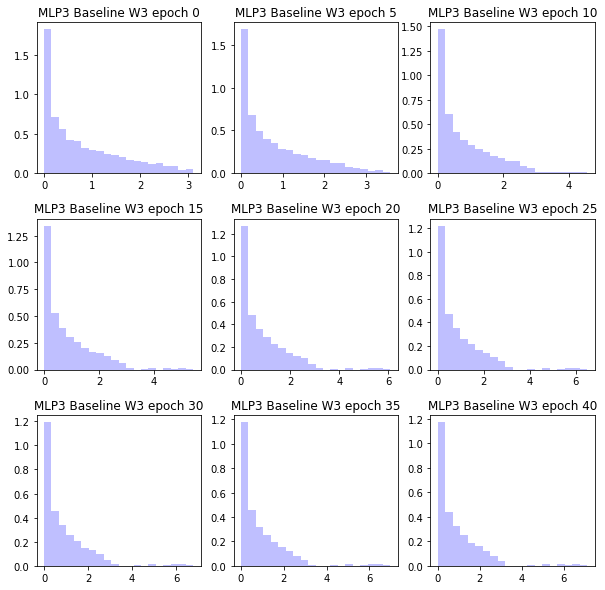

In [131]:
LAYER = 3
f, axes = plt.subplots(3,3)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,5)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = get_eigenvalues(modelfile, layer=LAYER)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("MLP3 Baseline W{} epoch {}".format(LAYER,epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#fig = plt.figure()
#fig.savefig('MLP_W2_ESDs.png')

### Fit Marchenko Pastur to ESD

#### Not so easy

0 4.110984563827515


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


(0, 3)

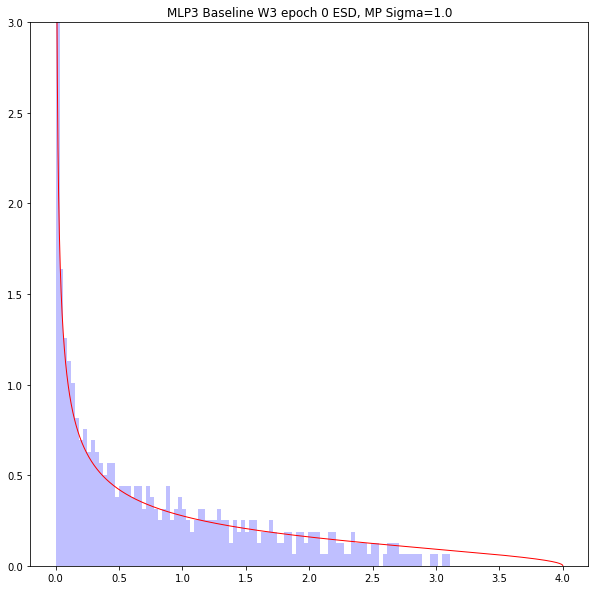

In [176]:
LAYER=3
EPOCH=0
Q = 1.0
SIGMA=1.0

eigenvalues = get_eigenvalues(BASELINE_per_epoch_weightfile.format(EPOCH), LAYER)
plt.hist(eigenvalues, bins=100, alpha=0.25, color='blue', density=True);

ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)+1.0
print(x_min, x_max)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("MLP3 Baseline W{} epoch {} ESD, MP Sigma={}".format(LAYER,EPOCH,SIGMA));
plt.ylim([0,3])


0 4.557096


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


(0, 3)

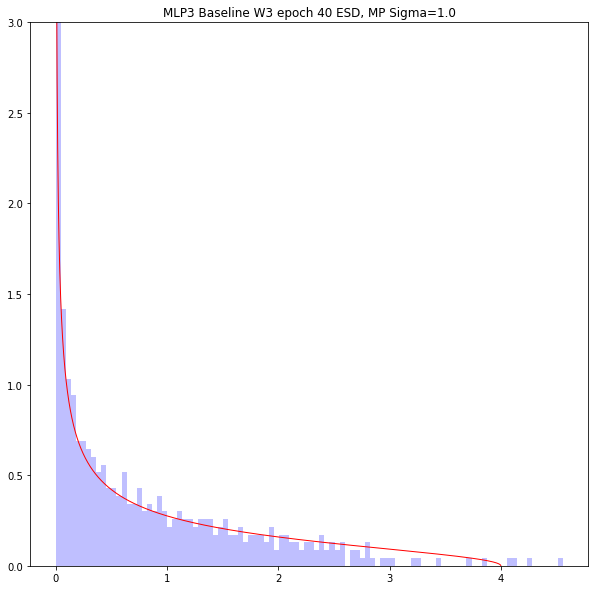

In [177]:
LAYER=3
EPOCH=0
Q = 1.0
SIGMA=1.0

eigenvalues = get_eigenvalues(BASELINE_per_epoch_weightfile.format(10), layer=3)
plt.hist(eigenvalues, bins=100, alpha=0.25, color='blue', density=True);


ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)
print(x_min, x_max)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=Sigma)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("MLP3 Baseline W{} epoch {} ESD, MP Sigma={}".format(LAYER,epoch,Sigma));
plt.ylim([0,3])


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


(0, 3)

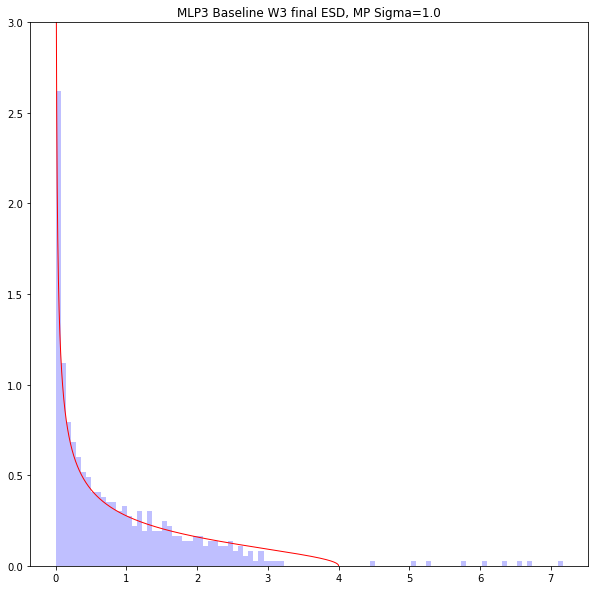

In [173]:
eigenvalues = get_eigenvalues(BASELINE_final_weightfile, LAYER)
plt.hist(eigenvalues, bins=100, alpha=0.25, color='blue', density=True);


ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("MLP3 Baseline W{} final ESD, MP Sigma={}".format(LAYER,SIGMA));
plt.ylim([0,3])

## Scree Plots

In [113]:
def scree_plot(filename, colors=['blue', 'green']):
    
    model.load_weights(filename)
    ev7s, ev8s = matrix_eigenvalues()
    eigvals = ev7s
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals, colors[0], linewidth=1)

    eigvals = ev8s
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals,  colors[1], linewidth=1)


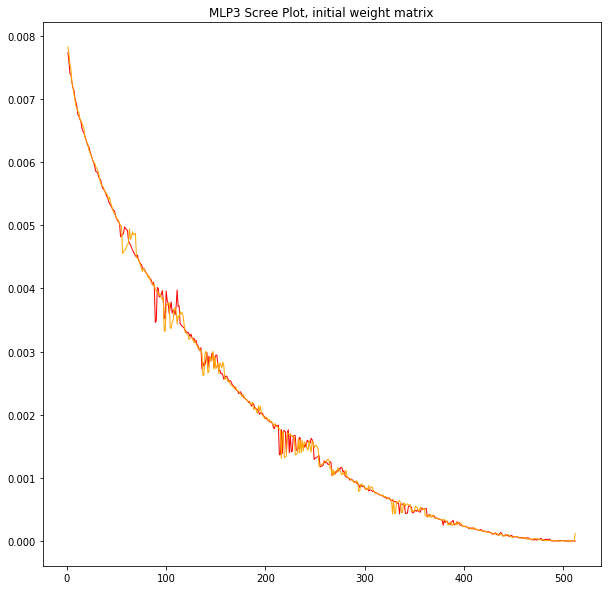

In [114]:
scree_plot(BASELINE_init_weighfile, colors=['red', 'orange'])
plt.title("MLP3 Scree Plot, initial weight matrix")
plt.show()


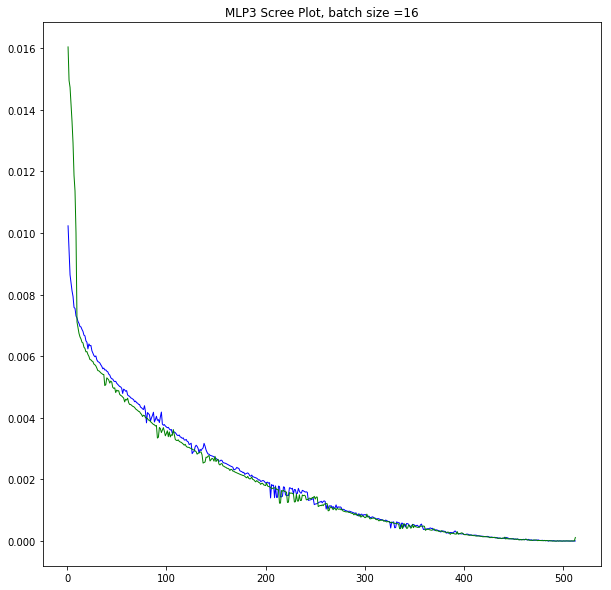

In [115]:
scree_plot(BASELINE_final_weightfile)
plt.title("MLP3 Scree Plot, batch size =16")
plt.show()


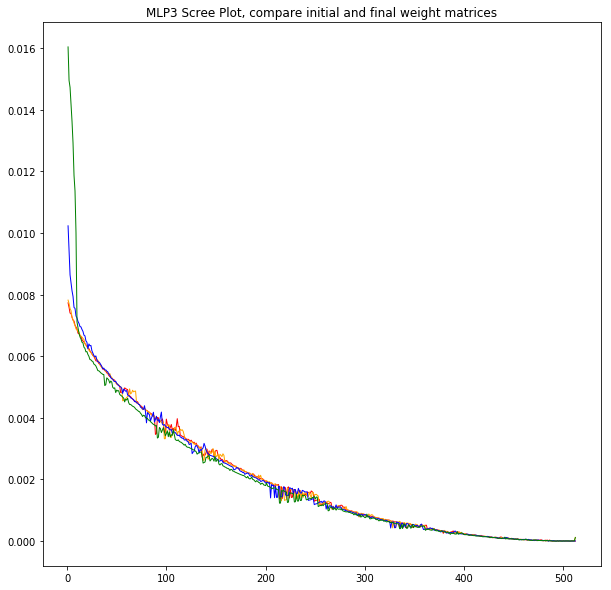

In [117]:
scree_plot(BASELINE_init_weighfile, colors=['red', 'orange'])
scree_plot(BASELINE_final_weightfile)
plt.title("MLP3 Scree Plot, compare initial and final weight matrices")
plt.show()